In [4]:
!pip install tensorflow-gpu==1.13.1
!pip install tensorflow==1.13.1
!pip install keras==2.0.8
!pip install imutils

     |████████████████████████████████| 345.0 MB 2.1 kB/s  eta 0:00:01
     |████████████████████████████████| 367 kB 34.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.2 MB 36.3 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 4.7 MB/s  eta 0:00:01
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.4.1 requires tensorboard~=2.4, but you have tensorboard 1.13.1 which is incompatible.
tensorflow 2.4.1 requires tensorflow-estimator<2.5.0,>=2.4.0, but you

In [5]:
#Checking TF version
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
tf.__version__

'1.13.1'

In [6]:
#Install Matterport
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 137.67 MiB | 37.71 MiB/s, done.
Resolving deltas: 100% (558/558), done.


In [7]:
# Installing Matterport and downloading pretrained model for Coco Dataset
import os
os.chdir("./Mask_RCNN")
!python setup.py install
!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn

## Imports

In [8]:
import mrcnn
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN
from mrcnn import utils
import numpy as np
from numpy import zeros
from numpy import asarray
import colorsys
import argparse
import imutils
import random
import cv2
import os
from os import listdir
import time
from matplotlib import pyplot
from matplotlib.patches import Rectangle
%matplotlib inline
from keras.models import load_model
from xml.etree import ElementTree

Using TensorFlow backend.


In [9]:
# Setting some matterport configs
class myMaskRCNNConfig(Config):
    # give the configuration a recognizable name
    NAME = "MaskRCNN_config"
 
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Use small images for faster training. 
    #IMAGE_MIN_DIM = 128
    #IMAGE_MAX_DIM = 128
 
    # number of classes (we would normally add +1 for the background)
    # kangaroo + BG
    NUM_CLASSES = 3+1
   
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 10
    
    # Reduce training ROIs per image because the images are small and have few objects.
    #TRAIN_ROIS_PER_IMAGE = 20
    # Use smaller anchors because our image and objects are small
    #RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels
    # set appropriate step per epoch and validation step
    #STEPS_PER_EPOCH = len(X_train)//(GPU_COUNT*IMAGES_PER_GPU)
    #VALIDATION_STEPS = len(X_val)//(GPU_COUNT*IMAGES_PER_GPU)


    # Learning rate
    LEARNING_RATE=0.006
    
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
    # setting Max ground truth instances
    MAX_GT_INSTANCES=10

config = myMaskRCNNConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.006
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Loading a custom Dataset

In [10]:
# class KangarooDataset(Dataset):
#     # load the dataset definitions
#     def load_dataset(self, dataset_dir, is_train=True):
        
#         # Add classes. We have only one class to add.
#         self.add_class("dataset", 1, "Signature")
#         self.add_class("dataset",2,"Stamp")
#         self.add_class("dataset",3,"Others")
        
#         # define data locations for images and annotations
#         images_dir = dataset_dir + '/images/'
#         annotations_dir = dataset_dir + '/annots/'
        
#         # Iterate through all files in the folder to 
#         #add class, images and annotaions
#         for filename in listdir(images_dir):
            
#             # extract image id
#             image_id = filename[:-4]
#             #image_id = filename.split('-')[1].split('.')[0]
            
#             # skip bad images
# #             if image_id in ['00090']:
# #                 continue
#             # skip some images if we are building the train set
#             #print(image_id)
#             if is_train and int(image_id) >=63:
#                 continue
#             # skip some images if we are building the test/val set
#             if not is_train and int(image_id) <63:
#                 continue
            
#             # setting image file
#             img_path = images_dir + filename
            
#             # setting annotations file
#             ann_path = annotations_dir + filename[:-3] + 'xml'
            
#             # adding images and annotations to dataset
#             self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
# # extract bounding boxes from an annotation file
#     def extract_boxes(self, filename):
        
#         # load and parse the file
#         tree = ElementTree.parse(filename)
#         # get the root of the document
#         root = tree.getroot()
#         # extract each bounding box
#         boxes = list()
#         for box in root.findall('.//bndbox'):
#             xmin = int(box.find('xmin').text)
#             ymin = int(box.find('ymin').text)
#             xmax = int(box.find('xmax').text)
#             ymax = int(box.find('ymax').text)
#             coors = [xmin, ymin, xmax, ymax]
#             boxes.append(coors)
        
#         # extract image dimensions
#         width = int(root.find('.//size/width').text)
#         height = int(root.find('.//size/height').text)
#         return boxes, width, height
# # load the masks for an image
#     """Generate instance masks for an image.
#        Returns:
#         masks: A bool array of shape [height, width, instance count] with
#             one mask per instance.
#         class_ids: a 1D array of class IDs of the instance masks.
#     """
#     def load_mask(self, image_id):
#         # get details of image
#         info = self.image_info[image_id]
        
#         # define anntation  file location
#         path = info['annotation']
        
#         # load XML
#         boxes, w, h = self.extract_boxes(path)
       
#         # create one array for all masks, each on a different channel
#         masks = zeros([h, w, len(boxes)], dtype='uint8')
        
#         # create masks
#         class_ids = list()
#         for i in range(len(boxes)):
#             box = boxes[i]
#             row_s, row_e = box[1], box[3]
#             col_s, col_e = box[0], box[2]
#             masks[row_s:row_e, col_s:col_e, i] = 1
#             class_ids.append(self.class_names.index('Singature'))
#         return masks, asarray(class_ids, dtype='int32')
# # load an image reference
#     """Return the path of the image."""
#     def image_reference(self, image_id):
#         info = self.image_info[image_id]
#         print(info)
#         return info['path']

In [11]:
class HSDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define classes
        self.add_class("dataset", 1, "Signature")
        self.add_class("dataset", 2, "Stamp")
        self.add_class("dataset", 3, "Others")
        
        # define data locations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
       
             
		# find all images
        for filename in listdir(images_dir):
            #print(filename)
			# extract image id
            image_id = filename[:-4]
			#print('IMAGE ID: ',image_id)
			
			# skip all images after 62 if we are building the train set
            if is_train and int(image_id) >= 63:
                continue
			# skip all images before 62 if we are building the test/val set
            if not is_train and int(image_id) < 63:
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path, class_ids = [0,1,2,3])


	# extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
		# load and parse the file
        tree = ElementTree.parse(filename)
		# get the root of the document
        root = tree.getroot()
		# extract each bounding box
        boxes = list()
        for box in root.findall('.//object'):
            name = box.find('name').text   #Add label name to the box list
            xmin = int(box.find('./bndbox/xmin').text)
            ymin = int(box.find('./bndbox/ymin').text)
            xmax = int(box.find('./bndbox/xmax').text)
            ymax = int(box.find('./bndbox/ymax').text)
            coors = [xmin, ymin, xmax, ymax, name]
            boxes.append(coors)
		# extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

	# load the masks for an image
    def load_mask(self, image_id):
		# get details of image
        info = self.image_info[image_id]
		# define box file location
        path = info['annotation']
        #return info, path
        
        
		# load XML
        boxes, w, h = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            
            
            # box[4] will have the name of the class 
            if (box[4] == 'Signature'):
                masks[row_s:row_e, col_s:col_e, i] = 1
                class_ids.append(self.class_names.index('Signature'))
            elif(box[4] == 'Stamp'):
                masks[row_s:row_e, col_s:col_e, i] = 2
                class_ids.append(self.class_names.index('Stamp')) 
            elif(box[4] == 'Others'):
                masks[row_s:row_e, col_s:col_e, i] = 3
                class_ids.append(self.class_names.index('Others'))
          
        return masks, asarray(class_ids, dtype='int32')
        

	# load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']


In [12]:
os.chdir("../")
dataset_dir = "/kaggle/input/handwriting-detection"
# prepare train set
train_set = HSDataset()
train_set.load_dataset(dataset_dir, is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare test/val set
test_set = HSDataset()
test_set.load_dataset(dataset_dir, is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 62
Test: 16


In [13]:
train_set.image_info[0]

{'id': '029',
 'source': 'dataset',
 'path': '/kaggle/input/handwriting-detection/images/029.jpg',
 'annotation': '/kaggle/input/handwriting-detection/annots/029.xml',
 'class_ids': [0, 1, 2, 3]}

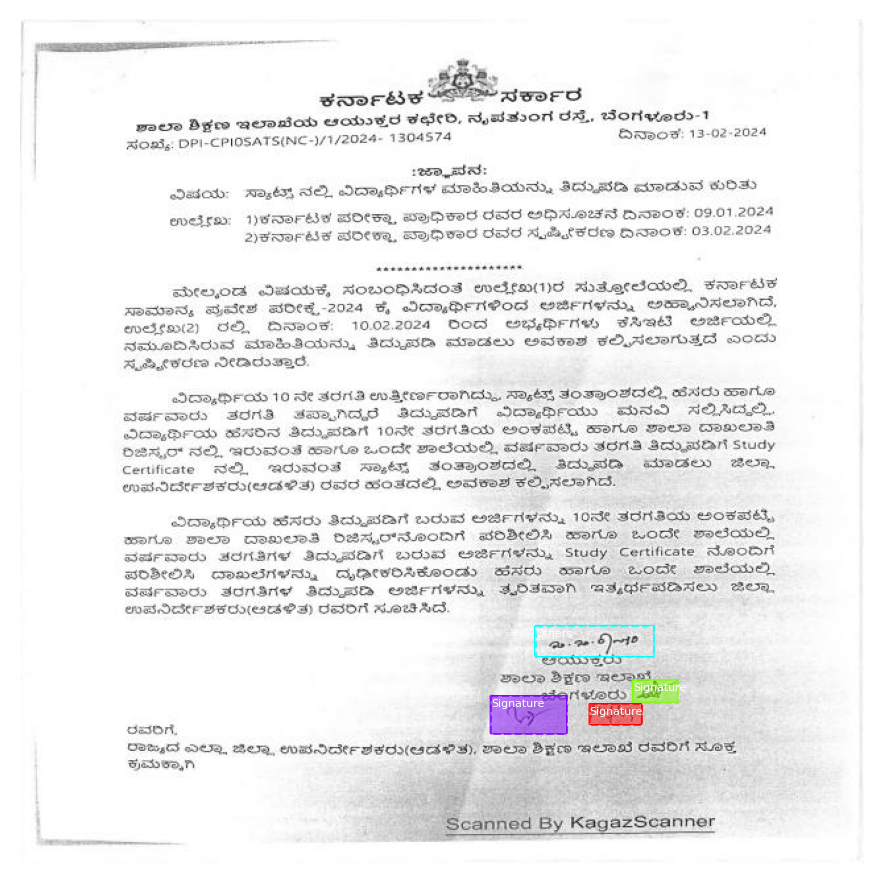

In [14]:
# Looking to an example
image_id = 0
image = train_set.load_image(image_id)

mask, class_ids = train_set.load_mask(image_id)
bbox = utils.extract_bboxes(mask)
visualize.display_instances(image,bbox,mask, class_ids, train_set.class_names)

In [15]:
# Looking to an example
test_set.image_info[1]

{'id': '066',
 'source': 'dataset',
 'path': '/kaggle/input/handwriting-detection/images/066.jpg',
 'annotation': '/kaggle/input/handwriting-detection/annots/066.xml',
 'class_ids': [0, 1, 2, 3]}

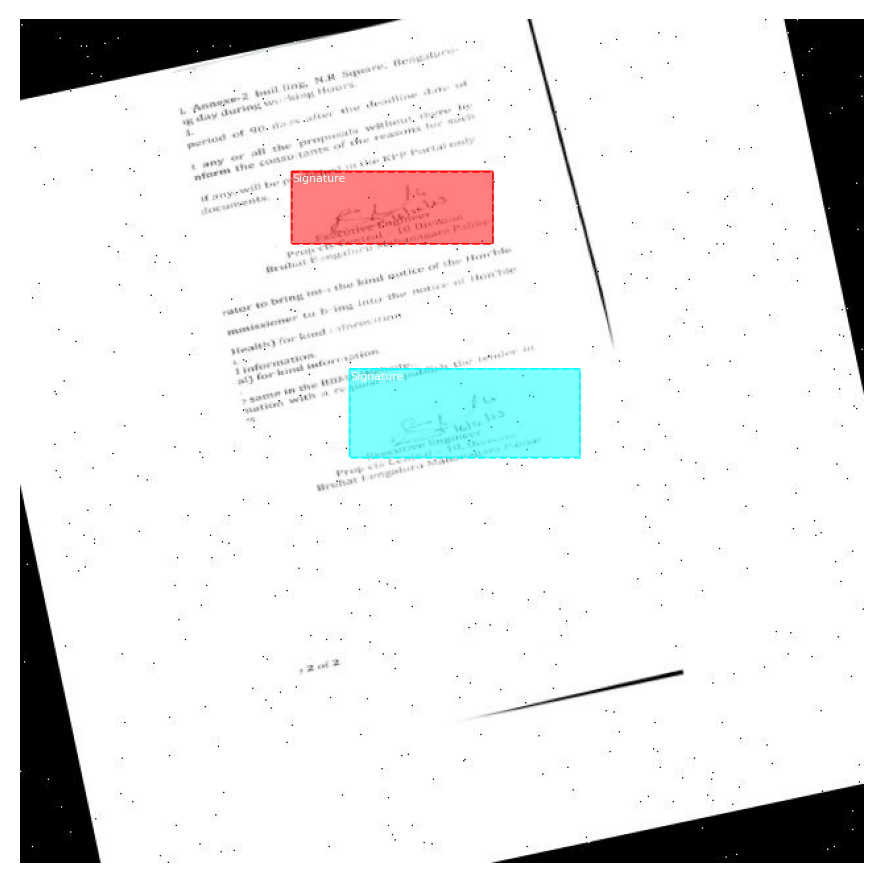

In [16]:
# Looking to an example
image_id = 1
image = test_set.load_image(image_id)

mask, class_ids = test_set.load_mask(image_id)
bbox = utils.extract_bboxes(mask)
visualize.display_instances(image,bbox,mask, class_ids, test_set.class_names)

## Training the model

In [17]:
print("Loading Mask R-CNN model...")
model = modellib.MaskRCNN(mode="training", config=config, model_dir='/kaggle/working/Mask_RCNN')
#load the weights for COCO
model.load_weights('/kaggle/working/Mask_RCNN/mask_rcnn_coco.h5', 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

Loading Mask R-CNN model...


In [18]:
## train heads with higher lr to speedup the learning
model.train(train_set, test_set, learning_rate=2*config.LEARNING_RATE, epochs=30, layers='heads')
history = model.keras_model.history.history


Starting at epoch 0. LR=0.012

Checkpoint Path: /kaggle/working/Mask_RCNN/maskrcnn_config20240424T0447/mask_rcnn_maskrcnn_config_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistri

/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
 9/10 [==========================>...] - ETA: 45s - loss: 4.0351 - rpn_class_loss: 0.4490 - rpn_bbox_loss: 1.7117 - mrcnn_class_loss: 0.8871 - mrcnn_bbox_loss: 0.7801 - mrcnn_mask_loss: 0.2072     

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2142: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


10/10 [==============================] - 1272s - loss: 3.8225 - rpn_class_loss: 0.4389 - rpn_bbox_loss: 1.6966 - mrcnn_class_loss: 0.7984 - mrcnn_bbox_loss: 0.7021 - mrcnn_mask_loss: 0.1865 - val_loss: 2.4708 - val_rpn_class_loss: 0.1138 - val_rpn_bbox_loss: 0.8928 - val_mrcnn_class_loss: 0.0618 - val_mrcnn_bbox_loss: 0.8620 - val_mrcnn_mask_loss: 0.5404


## Evaluation

In [19]:
# Best model
model_path = '/kaggle/working/Mask_RCNN/maskrcnn_config20240424T0447/mask_rcnn_maskrcnn_config_0000.h5'
#Loading the model in the inference mode
model = modellib.MaskRCNN(mode="inference", config=config, model_dir='./')
# loading the trained weights o the custom dataset
model.load_weights(model_path, by_name=True)

Re-starting from epoch 0


In [24]:
def compute_ap_range(gt_box, gt_class_id, gt_mask,
                     pred_box, pred_class_id, pred_score, pred_mask,
                     iou_thresholds=None, verbose=1):
    """Compute AP over a range or IoU thresholds. Default range is 0.5-0.95."""
    # Default is 0.5 to 0.95 with increments of 0.05
    if iou_thresholds is None:
        iou_thresholds = np.arange(0.5, 1.0, 0.05)
    
    # Compute AP over range of IoU thresholds
    AP = []
    for iou_threshold in iou_thresholds:
        ap, precisions, recalls, overlaps =\
            utils.compute_ap(gt_box, gt_class_id, gt_mask,
                        pred_box, pred_class_id, pred_score, pred_mask,
                        iou_threshold=iou_threshold)
        if verbose:
            print("AP @{:.2f}:\t {:.3f}".format(iou_threshold, ap))
        AP.append(ap)
    AP = np.array(AP).mean()
    if verbose:
        print("AP @{:.2f}-{:.2f}:\t {:.3f}".format(
            iou_thresholds[0], iou_thresholds[-1], AP))
    return AP


In [25]:
def evaluate_model(dataset, model, cfg):
    precisions = []
    recalls = []
    APs_50 = []
    APs_50_95 = []
    for image_id in dataset.image_ids:
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # convert pixel values (e.g. center)
        scaled_image = modellib.mold_image(image, cfg)
        # convert image into one sample
        sample = np.expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate statistics, including AP
        AP, precision, recall, _ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs_50.append(AP)
        precisions.append(precision)
        recalls.append(recall)
        
        # Compute mAP@50-95
        APs_50_95 = compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                                           r["rois"], r["class_ids"], r["scores"], r['masks'],
                                           iou_thresholds=np.arange(0.5, 1.0, 0.05), verbose=0)

    # calculate the mean precision, recall, mAP@50, and mAP@50-95 across all images
    mean_precision = np.mean(precisions)
    mean_recall = np.mean(recalls)
    mAP_50 = np.mean(APs_50)
    mAP_50_95 = np.mean(APs_50_95)
    
    return mean_precision, mean_recall, mAP_50, mAP_50_95


In [28]:

mean_precision, mean_recall, mAP_50, mAP_50_95 = evaluate_model(test_set, model, config)




In [30]:
# Print the results
print("Mean Precision:", mean_precision)
print("Mean Recall:", mean_recall)
print("mAP@50:", mAP_50)
print("mAP@50-95:", mAP_50_95)

Mean Precision: 0.944
Mean Recall: 0.463
mAP@50: 0.449
mAP@50-95: 0.412
